# Capter5 决策树模型 
## ID3与C4.5决策树模型
### 建立决策树

In [9]:
import pandas as pd
import numpy as np
from graphviz import Digraph

class DecisionTree():
    def __init__(self, tree_type='ID3', eps = 0.01, cut_rate = 0.4):
        self.tree_type = tree_type
        self.eps = eps
        self.cut_rate = cut_rate
        self.id = 0

    def get_info_gain(self, data_df):
        label_p = data_df.groupby('label')['label'].count() / data_df.shape[0]
        label_p_log = np.log2(label_p.values)
        emp_prob = (label_p * label_p_log).sum() * -1
        g_lst = []
        for col in data_df.columns:
            if col == 'label':
                continue
            tmp_df = data_df.loc[:, [col, 'label']]
            label_count = tmp_df.groupby([col, 'label'])[col].count()
            fea_count = label_count.sum(level = col)
            fea_p = fea_count / data_df.shape[0]
            fea_label_p = label_count/fea_count
            fea_label_p_log = np.log2(fea_label_p)
            con_prob = (fea_p * fea_label_p * fea_label_p_log).sum() * -1
            g_lst.append(emp_prob - con_prob)
        return {'emp_prob' : emp_prob, 'gain_lst' : g_lst}

    def ID3_split(self, data_df):
        res = self.get_info_gain(data_df)
        g_lst = res['gain_lst']
        max_g = max(g_lst)
        if max_g < self.eps:
            return 
        return data_df.columns[g_lst.index(max_g)]

    def C45_split(self, data_df):
        res = self.get_info_gain(data_df)
        g_lst = res['gain_lst']
        gr_lst = [x/res['emp_prob'] for x in g_lst]
        max_r = max(gr_lst)
        if max_r < self.eps:
            return 
        return data_df.columns[gr_lst.index(max_r)]

    def get_sub_data(self, data, split_point):
        sub_data_dict = {}
        fea_grped = data.groupby(split_point)
        for name, grp in fea_grped:
            sub_data_dict[name] = grp
        return sub_data_dict
    
    def build_tree(self, data_df, level = 0, parent = None):
        root = {'level' : level, 'parent' : parent, 'id' : self.id}
        self.id = self.id + 1
        if data_df[data_df['label'] == data_df.iloc[0, -1]].shape[0] == data_df.shape[0]:
            label = data_df.iloc[0, -1]
            root['final_label'] = label
            root['info'] = {label : data_df.shape[0]}
            return root
        if self.tree_type == 'ID3':
            split_point = self.ID3_split(data_df)
        elif self.tree_type == 'C45':
            split_point = self.C45_split(data_df)
        else:
            print('算法类型不支持')
            return None
        if not split_point:
            label_count = data_df.groupby('label')['label'].count()
            root['final_label'] = label_count.idxmax()
            root['info'] = dict(label_count)
            return root
        root['info'] = split_point
        root['children'] = {}
        sub_data_dict = self.get_sub_data(data_df, split_point)
        for k, sub_data in sub_data_dict.items():
            if sub_data.shape[0] > 0:
                root['children'][k] = self.build_tree(sub_data, level + 1, root)
        return root

    def get_leaf_nodes(self, node, nodes):
        if 'final_label' in node:
            nodes[node['id']] = node
            return
        for k, v in node['children'].items():
            self.get_leaf_nodes(v, nodes)

    def combine_leaf_node(self, nodes):
        node_dict = {}
        for k, v in nodes.items():
            for kk, vv in v['info'].items():
                if kk not in node_dict:
                    node_dict[kk] = vv
                else:
                    node_dict[kk] = node_dict[kk] + vv
        max_num = {'num' : 0}
        for k, v in node_dict.items():
            if v > max_num['num']:
                max_num['num'] = v
                max_num['label'] = k
        return {'final_label' : max_num['label'], 'info' : node_dict}
            
    def get_cut_nodes(self, node, cut_nodes):
        if 'final_label' in node:
            return True
        flag_dict = {}
        for k, v in node['children'].items():
            flag = self.get_cut_nodes(v, cut_nodes)
            flag_dict[flag] = 1
        if False not in flag_dict:
            cut_nodes[node['id']] = node
        return False

    def cal_loss(self, leaf_nodes):
        res = 0
        for k, v in leaf_nodes.items():
            sum = 0
            num_lst = []
            for kk, vv in v['info'].items():
                sum = sum + vv
                num_lst.append(vv)
            prob_np = np.array([ float(x)/sum for x in num_lst ])
            prob_np_log = np.log2(prob_np)
            emp_entropy = np.sum(prob_np * prob_np_log) * -1
            res = res + (sum * emp_entropy)
        return self.cut_rate * len(leaf_nodes) + res

    def cut_branch(self, root):
        while True:
            cut_nodes = {}
            self.get_cut_nodes(root, cut_nodes)
            cut_flag = False
            for nid, node in cut_nodes.items():
                if 'visit' in node:
                    continue
                leaf_nodes = {}
                self.get_leaf_nodes(root, leaf_nodes)
                src_loss = self.cal_loss(leaf_nodes)
                new_node = self.combine_leaf_node(node['children'])
                for k, v in node['children'].items():
                    del leaf_nodes[v['id']]
                leaf_nodes[-1] = new_node
                dst_loss = self.cal_loss(leaf_nodes)
                if dst_loss <= src_loss:
                    del node['children']
                    node['final_label'] = new_node['final_label']
                    node['info'] = new_node['info']
                    cut_flag = True
                else:
                    node['visit'] = True
            if not cut_flag:
                break
        return root

    def predict(self, x_df, node):
        if 'final_label' in node:
            return node['final_label']
        fea_key = node['info'] 
        fea_val = node['children']
    
        if x_df[fea_key] not in fea_val:
            leaf_nodes = {}
            self.get_leaf_nodes(node, leaf_nodes)
            new_nodes = self.combine_leaf_node(leaf_nodes)
            return new_nodes['final_label']
        else:
            return self.predict(x_df, fea_val[x_df[fea_key]])

    def format_dot(self, dot, node, edge_label = ''):
        node_label = "{}_{}_{}".format(node['id'], node['level'], node['info'])
        dot.node(str(node['id']), label=node_label)
        if len(edge_label) != 0:
            dot.edge(str(node['parent']['id']), str(node['id']), label = edge_label)
        if 'final_label' in node:
            return
        for k, v in node['children'].items():
            self.format_dot(dot, v, str(k))

    def print_tree(self, root):
        dot = Digraph(comment='Decision Tree')
        self.format_dot(dot, root)
        return dot

### ID3模型

In [10]:
class ID3Model():
    def __init__(self, eps = 0.01, cut_rate = 0.4):
        self.tree = DecisionTree('ID3', eps, cut_rate)

    def fit(self, train_x, train_y):
        df = train_x.copy()
        df['label'] = train_y
        self.root = self.tree.build_tree(df)
        self.print_tree_before_cut = self.tree.print_tree(self.root)
        self.tree.cut_branch(self.root)
        self.print_tree_after_cut = self.tree.print_tree(self.root)

    def predict(self, x_df):
        y_pre = x_df.apply(self.tree.predict, axis=1, args=(self.root,))
        return y_pre.values

    def print_tree_before_cut(self):
        return self.before_dot

    def print_tree_after_cut(self):
        return self.after_dot

    def get_accuracy(self, gt_y, pre_y):
        diff = np.subtract(gt_y, pre_y)
        err = diff[diff!=0].shape[0]
        return 1 - err/gt_y.shape[0]

### C4.5模型

In [11]:
class C45Model():
    def __init__(self, eps = 0.01, cut_rate = 0.4):
        self.tree = DecisionTree('C45', eps, cut_rate)

    def fit(self, train_x, train_y):
        df = train_x.copy()
        df['label'] = train_y
        self.root = self.tree.build_tree(df)
        self.print_tree_before_cut = self.tree.print_tree(self.root)
        self.tree.cut_branch(self.root)
        self.print_tree_after_cut = self.tree.print_tree(self.root)

    def predict(self, x_df):
        y_pre = x_df.apply(self.tree.predict, axis=1, args=(self.root,))
        return y_pre.values

    def print_tree_before_cut(self):
        return self.before_dot

    def print_tree_after_cut(self):
        return self.after_dot

    def get_accuracy(self, gt_y, pre_y):
        diff = np.subtract(gt_y, pre_y)
        err = diff[diff!=0].shape[0]
        return 1 - err/gt_y.shape[0]

## 模型测试
### 准备测试数据

In [12]:
%matplotlib widget
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns

data = datasets.load_iris()
x_data = data.data
y_data = data.target
x_names = data.feature_names
y_names = data.target_names

data_np = np.column_stack((x_data, y_data))
np.random.shuffle(data_np)
data_cols = list(x_names.copy())
data_cols.append('labels')
df = pd.DataFrame(data_np, columns=data_cols)
for col in x_names:
    df[col] = pd.cut(df[col], 5, labels=range(5))

train_num = 120
train_x = df.iloc[:train_num, :4]
train_y = df.iloc[:train_num, 4:].values.reshape([train_num,])
test_x = df.iloc[train_num:, :4]
test_y = df.iloc[train_num:, 4:].values.reshape([df.shape[0] - train_num,])
#sns.pairplot(x_vars = x_names, y_vars = x_names, hue = 'labels', data = df)


### ID3模型测试

In [13]:
model = ID3Model()
model.fit(train_x, train_y)
pre_y = model.predict(test_x)
print('accuracy: %.2f' % model.get_accuracy(test_y, pre_y))

accuracy: 0.97


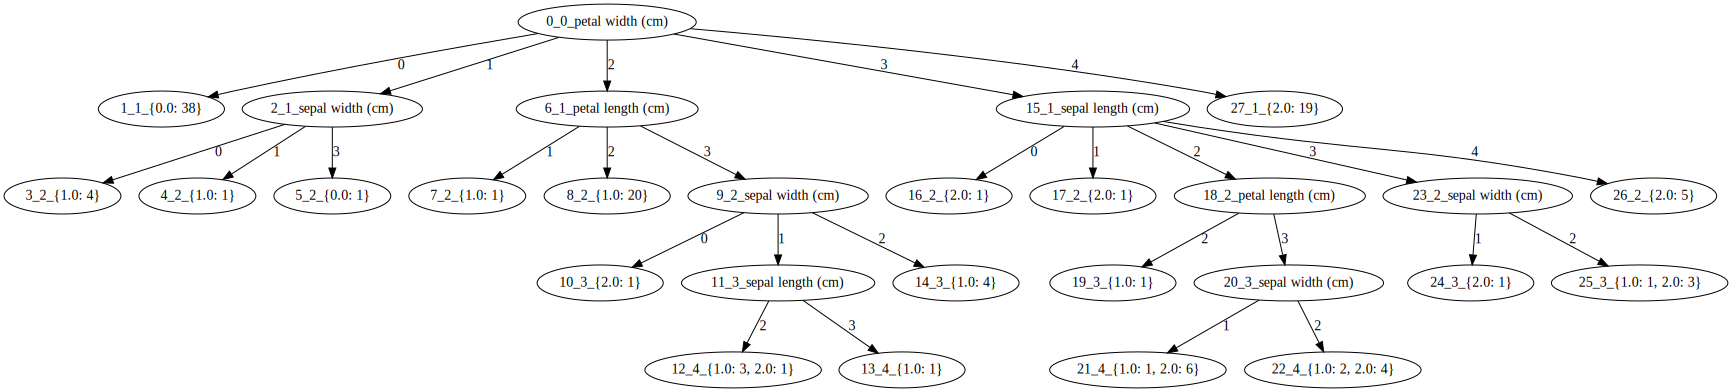

In [14]:
model.print_tree_before_cut

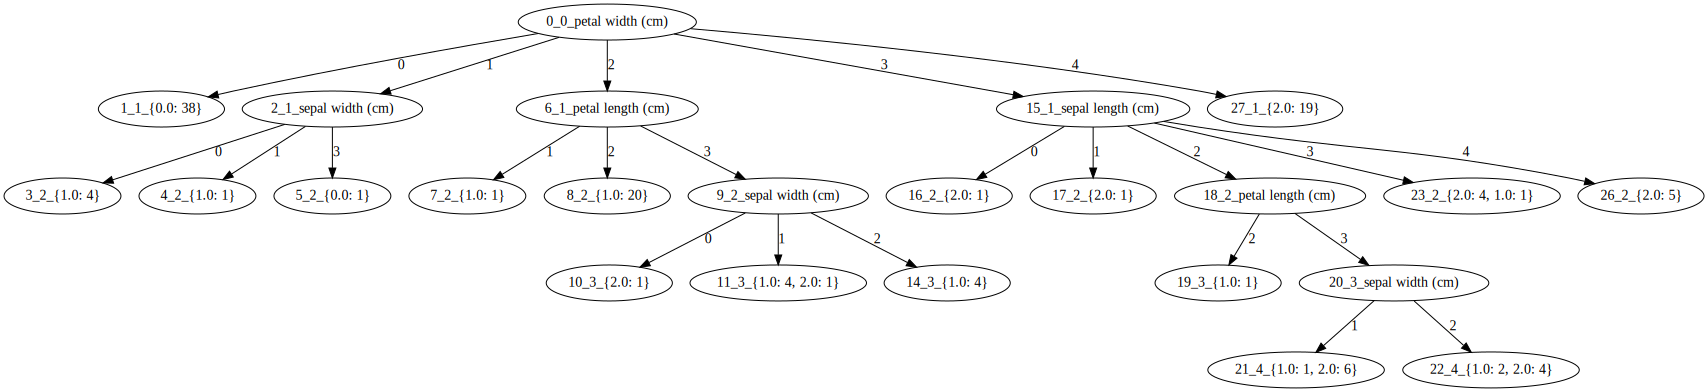

In [15]:
model.print_tree_after_cut

### C4.5模型测试

In [16]:
model = C45Model()
model.fit(train_x, train_y)
pre_y = model.predict(test_x)
print('accuracy: %.2f' % model.get_accuracy(test_y, pre_y))

accuracy: 0.97
